In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
df = pd.read_csv('cleaned_starcraft_data.csv')

In [59]:
X = df.drop(columns = ['LeagueIndex'])
y = df['LeagueIndex']

In [60]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 


The original data has very imbalanced classes. The highest leagues had less than 100 people each, while the middle leagues had over 500. This is a problem since most models assume an equal frequency of class distributions, so an uneven distribution could cause problems. 

I choose to use SMOTE and Random Under Sampling to resample the classes so we had equal amounts of each class in our training data. An added benefit of SMOTE is that it creates additional data for our model to train on, and more data generally tends to help improve the performance of a model. In our case, since we barely have 3000 datapoints as is, any additional data we can get is immensely valueable. 

I also tested using some form of stanrdization or normalization with the data, but I found it to decrease performance so I chose to not include it in the final model.

In [61]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
over = SMOTE()
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train_smote, y_train_smote = pipeline.fit_resample(X_train, y_train)

In [62]:
y_train.value_counts()

4    575
3    559
5    444
2    384
1    240
0    108
7     39
6     26
Name: LeagueIndex, dtype: int64

In [63]:
y_train_smote.value_counts()

0    575
4    575
1    575
5    575
2    575
6    575
3    575
7    575
Name: LeagueIndex, dtype: int64

In [64]:
codes = {
    0: "Bronze",
    1: "Silver", 
    2: "Gold", 
    3: "Platinum", 
    4: "Diamond", 
    5: "Master",
    6: "GrandMaster", 
    7: "Professional leagues"
}

In [65]:
#MODEL TESTING

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from yellowbrick.classifier import ROCAUC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt




In [66]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder=codes)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    

def plot_conf_matrix(model, y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=codes.values())
  disp.plot()
  plt.show()

def calc_metrics(y_test, y_pred, y_pred_prob):
  print('auc', roc_auc_score(y_test, y_pred_prob, multi_class = 'ovo'))
  print('acc', accuracy_score(y_test, y_pred))
  print('f1', f1_score(y_test, y_pred, average='macro'))
  print('recall', recall_score(y_test, y_pred, average = 'macro'))
  print('precision', precision_score(y_test, y_pred, average = 'macro'))

def do_what_i_want(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  if type(model) == GridSearchCV:
    print('best_parameters', model.best_params_)
  y_pred = model.predict(X_test)
  y_pred_prob = model.predict_proba(X_test)

  calc_metrics(y_test, y_pred, y_pred_prob)
  plot_conf_matrix(model, y_test, y_pred)
  plot_ROC_curve(model, X_train, y_train, X_test, y_test)


In [67]:
param_grid = { 
    'n_estimators':[100,200,500],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy', 'log_loss']
}

For my final model I build a Random Forest Classifier. In my testing I built many models including more complex models like XGBoost and a Neural Network. But these models all performed worse than the Random Forest, which I believe to be due to the fact that we don't have enough data for these more complex models. The random forest strikes a nice midle ground where it is complex enough to capture most things, but not so complex that it overfits to training data. 

As the project description did not specify, I tried to maximize my f1 score as for a multiclass problem, f1 is much less lenient. I choose not to look at accuracy as for an imbalanced classification problem such as this one, accuracy can too heavily reward picking the majority classes. 

best_parameters {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 500}
auc 0.8734325033221477
acc 0.41216879293424924
f1 0.45489680817684697
recall 0.47239589953422145
precision 0.4442631769842455


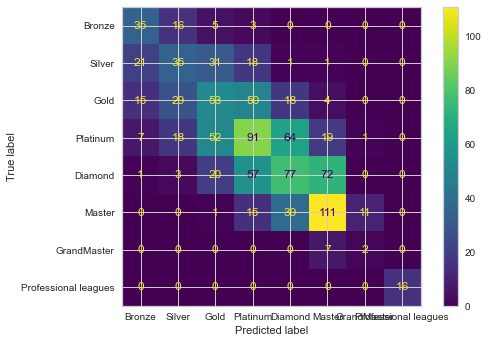

/Users/Rahul/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


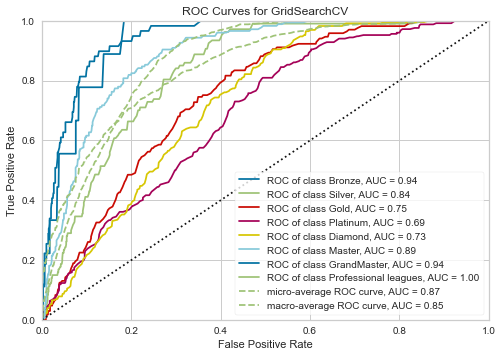

In [71]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_cv=GridSearchCV(rf,param_grid, scoring = 'f1_macro')
do_what_i_want(rf_cv, X_train_smote, X_test, y_train_smote, y_test)


In [41]:
best_rf = rf_cv.best_estimator_

<AxesSubplot:>

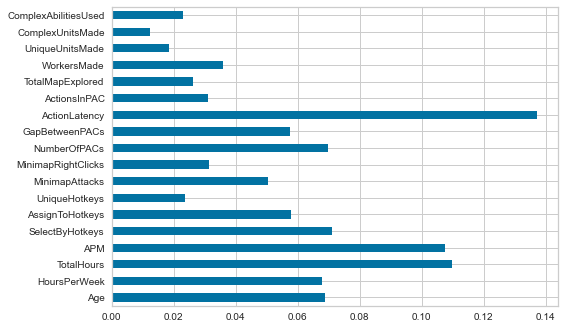

In [42]:
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_smote.columns)
feat_importances.plot(kind='barh')

Below is an example where we maximized accuracy if we decided overall accurary is better than properly predicting each class. 

/Users/Rahul/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/Rahul/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Rahul/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Rahul/o

best_parameters {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 500}
auc 0.8753564287357581
acc 0.42885181550539747
f1 0.4511112558304629
recall 0.4817466075345329
precision 0.4381096503986078


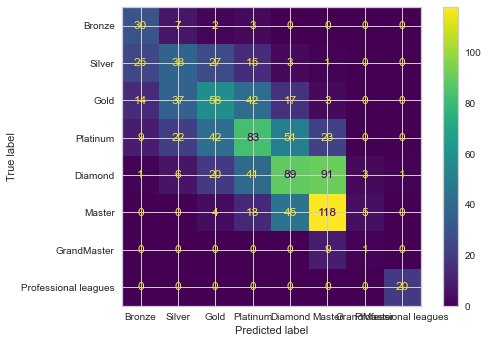

/Users/Rahul/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


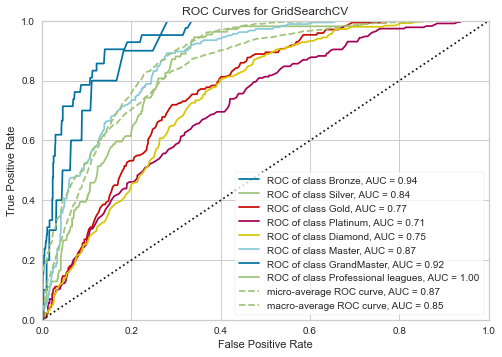

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs = -1)
rf_cv=GridSearchCV(rf,param_grid, scoring = 'accuracy')
do_what_i_want(rf_cv, X_train_smote, X_test, y_train_smote, y_test)
